# Ensemble estimators

In this part, we build ensemble estimators, which make predictions based on the predictions of base estimators. To avoid overfitting, we train the ensemble estimators on the cross-validation set rather than the training set we used for the training of base estimators. 

We try 2 strategies, weighted average and Ridge regression, for building ensemble estimators.

In [1]:
import sys
import traceback
import pandas as pd
import numpy as np
import time
from copy import deepcopy

from sklearn.base import BaseEstimator
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix

from sklearn.linear_model import Ridge, RidgeCV

from scipy import sparse

import pickle

from IPython.display import display, HTML, Markdown

import matplotlib
import matplotlib.pyplot as plt

import seaborn as sns
pd.set_option('display.width', 15000)
pd.set_option('display.max_columns', 100)
sns.set_style("whitegrid", {'axes.grid' : False})
sns.set_context('poster')
%matplotlib inline

from surprise import Dataset, Reader
from surprise import NormalPredictor, BaselineOnly, SVD, SVDpp, NMF, \
SlopeOne, CoClustering, KNNBasic, KNNWithMeans, KNNBaseline

from recommender import plot_cm, get_results, show_results, IO, show_summaries
from recommender import ModeClassifier, BaselineMean, BaselineRegression, ALS1, ALS2, RS_surprise

In [2]:
def get_base_predictions(results, is_successful, datanames, thres=0):
    ys_base_train = []
    ys_base_test = []
    ys_base_cv = []
    weights = []
    for i in range(len(is_successful)):
        if not is_successful[i]:
            continue
        model = IO(datanames[i]).read_pickle()
        if model.cv_r2 <= thres:
            continue
        weights.append(model.cv_r2)
        del model
        ys_base_train.append(results[i][0][0][0])
        ys_base_test.append(results[i][0][1][0])
        ys_base_cv.append(results[i][0][2][0])
    ys_base_train = np.array(ys_base_train).transpose()
    ys_base_test = np.array(ys_base_test).transpose()
    ys_base_cv = np.array(ys_base_cv).transpose()
    weights = np.array(weights) / np.sum(weights)
    return ys_base_train, ys_base_test, ys_base_cv, weights

In [3]:
city = 'test'
fig_dir = 'figs/modeling/{}/'.format(city)
data_dir = 'data/{}/'.format(city)

results = IO(data_dir + 'results/results.pkl').read_pickle()
is_successful = IO(data_dir + 'results/is_successful.pkl').read_pickle()
datanames = IO(data_dir + 'results/datanames.pkl').read_pickle()

ys_base_train, ys_base_test, ys_base_cv, weights = get_base_predictions(results, is_successful, datanames)
X_train, y_train, X_test, y_test, X_cv, y_cv = IO(data_dir + 'data_split.pkl').read_pickle()

In [4]:
class RS_ensemble(BaselineRegression):
    def __init__(self, algorithm='avg', classification=False):
        if not algorithm in ['avg', 'ridge']:
            raise NotImplementedError('Algorithm not implemented.')
        self.algorithm = algorithm
        self.fitted = False
        self.classification = classification
        self.time_fitting = []
        self.time_predict = []
        self.cv_r2 = None
        
    def _fit_avg(self, weights):
        self.weights = weights
        return self
    
    def _fit_ridge(self, ys_base, y):
        self.estimator = RidgeCV(normalize=True).fit(ys_base, y)
        return self
    
    def fit(self, ys_base=None, y=None, weights=None):
        t0 = time.time()
        if self.algorithm == 'avg':
            self._fit_avg(weights)
        elif self.algorithm == 'ridge':
            self._fit_ridge(ys_base, y)
        self.fitted = True
        self.time_fitting.append(time.time() - t0)
        return self
    
    def _predict_regression(self, ys_base):
        if self.algorithm == 'avg':
            return ys_base.dot(self.weights)
        elif self.algorithm == 'ridge':
            return self.estimator.predict(ys_base)

### Ensemble (weighted average)

Fitting time: 0.0000 s.  
            RMSE on training set: 0.8115.  
            RMSE on test set: 1.3059.  
            $R^2$ on training set: 0.6788.   
            $R^2$ on test set: 0.1897.  
            Classification accuracy on training set: 0.4174.  
            Classification accuracy on test set: 0.2529.
            

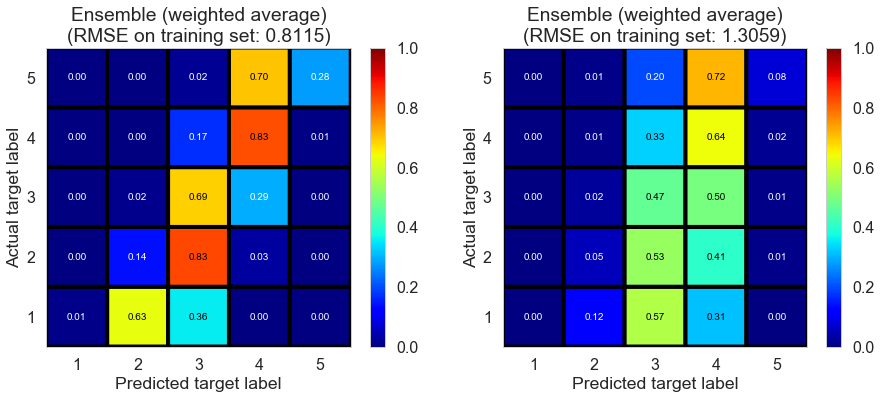

In [9]:
ens = RS_ensemble(algorithm='avg').fit(ys_base=ys_base_cv, y=y_cv, weights=weights)
show_results(ens, 'Ensemble (weighted average)', X_train=ys_base_train, y_train=y_train, \
             X_test=ys_base_test, y_test=y_test, show_cv=False)

### Ensemble (regression)

Fitting time: 0.0040 s.  
            RMSE on training set: 0.9146.  
            RMSE on test set: 1.3028.  
            $R^2$ on training set: 0.5920.   
            $R^2$ on test set: 0.1934.  
            Classification accuracy on training set: 0.3583.  
            Classification accuracy on test set: 0.2509.
            

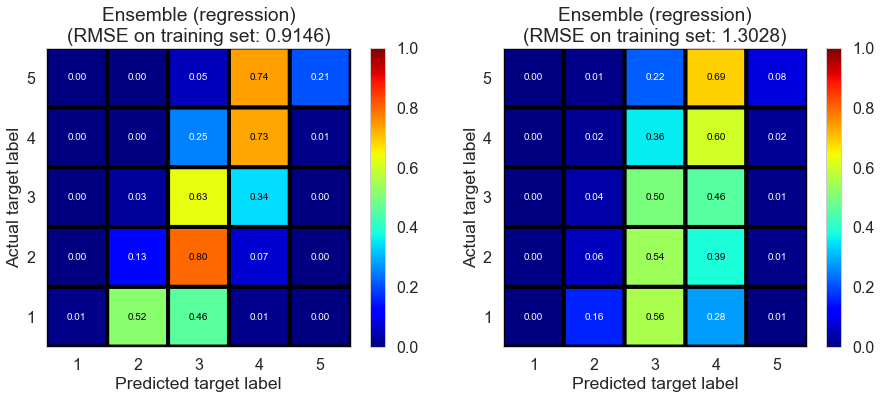

In [10]:
ens = RS_ensemble(algorithm='ridge').fit(ys_base=ys_base_cv, y=y_cv, weights=weights)
show_results(ens, 'Ensemble (regression)', X_train=ys_base_train, y_train=y_train, \
             X_test=ys_base_test, y_test=y_test, show_cv=False)